In [2]:
import os
from glob import glob
import random
from keras.utils import array_to_img

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

from chapter9.functions import get_model

2022-12-12 12:46:26.767880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 12:46:26.833783: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
%aimport chapter9

In [5]:
input_img_paths = sorted(glob("../../data/images/*.jpg"))
target_paths = sorted(glob("../../data/annotations/trimaps/*.png"))

#### Checking the list of Inputs and Targets:

In [6]:
print(f"Inputs -> {type(input_img_paths)}\nTargets -> {type(target_paths)}\n")
for i in range(5):
    print(f"Input Path:\n{input_img_paths[i]}\nTarget Path:\n{target_paths[i]}\n")

Inputs -> <class 'list'>
Targets -> <class 'list'>

Input Path:
../../data/images/Abyssinian_1.jpg
Target Path:
../../data/annotations/trimaps/Abyssinian_1.png

Input Path:
../../data/images/Abyssinian_10.jpg
Target Path:
../../data/annotations/trimaps/Abyssinian_10.png

Input Path:
../../data/images/Abyssinian_100.jpg
Target Path:
../../data/annotations/trimaps/Abyssinian_100.png

Input Path:
../../data/images/Abyssinian_101.jpg
Target Path:
../../data/annotations/trimaps/Abyssinian_101.png

Input Path:
../../data/images/Abyssinian_102.jpg
Target Path:
../../data/annotations/trimaps/Abyssinian_102.png



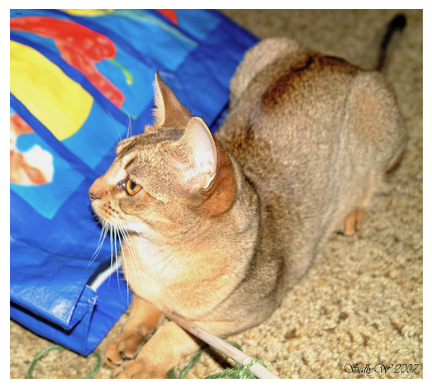

In [7]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))
plt.show()

In [8]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:,:,0])
    plt.show()

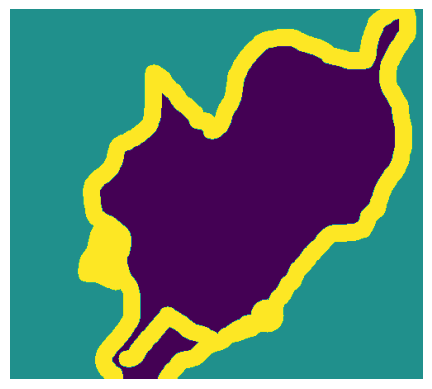

In [9]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [10]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [11]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
            load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [12]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [13]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [14]:
model = get_model(img_size=img_size, num_classes=3)

2022-12-12 12:46:48.165682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-12 12:46:48.167768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-12 12:46:48.167790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-12 12:46:48.169410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-12 12:46:48.169436: I tensorflow/com

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

callbacks = [
        tf.keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
        ]

In [29]:
def batch_gen(gen_obj, batch_size:int=10):
    count = 0
    result = None
    for x_i, y_i in gen_obj:
        if result:
            X, y = result
            x_i = np.reshape(x_i, (1, 200, 200, 3))
            y_i = np.reshape(y_i, (1, 200, 200, 1))
            X = np.concatenate((X, x_i), axis=0)
            y = np.concatenate((y, y_i), axis=0)
            result = (X, y)
        elif not result:
            x_i = np.reshape(x_i, (1, 200, 200, 3))
            y_i = np.reshape(y_i, (1, 200, 200, 1))
            result = (x_i, y_i)
        count += 1
        if count % batch_size == 0:
            yield count, result
            result = None

def validation_batch(val_imgs, val_labels, batch_size):
    result_x = np.zeros((1, 200, 200, 3), dtype="float")
    result_y = np.zeros((1, 200, 200, 1), dtype="float")
    for count in range(batch_size):
        i = np.random.randint(0, len(val_imgs))
        v_x = val_imgs[i]
        v_y = val_labels[i]
        result_x = np.concatenate((result_x, np.reshape(v_x, (1, 200, 200, 3))), axis=0)
        result_y = np.concatenate((result_y, np.reshape(v_y, (1, 200, 200, 1))), axis=0)
    yield (result_x[1:], result_y[1:])

In [34]:
datazip = ((img, label) for img, label in zip(train_input_imgs, train_targets))
for i in range(5):
    x, y = next(validation_batch(val_input_imgs, val_targets, 20))
    print(x.shape, y.shape)

(20, 200, 200, 3) (20, 200, 200, 1)
(20, 200, 200, 3) (20, 200, 200, 1)
(20, 200, 200, 3) (20, 200, 200, 1)
(20, 200, 200, 3) (20, 200, 200, 1)
(20, 200, 200, 3) (20, 200, 200, 1)


In [ ]:
# os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda/"
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
history = []
for count, (img, target) in batch_gen(datazip, 20):
    print(count)
    val_data = validation_batch(val_input_imgs, val_targets, 20)
    batch_history = model.fit(img, target,
                        epochs=50,
                        callbacks=callbacks,
                        validation_data=next(val_data))
    history.append(batch_history)
    tf.keras.backend.clear_session()

In [48]:
# print(len(history))
# print(history[0].history['loss'])
def make_history(history_list):
    result, val = ([], [])
    for i in range(len(history_list)):
        result.append(history[i].history['loss'])
        val.append(history[i].history['val_loss'])
    return result, val

In [51]:
loss, val_loss = make_history(history)
loss = np.asarray(loss)
val_loss = np.asarray(val_loss)
print(loss.shape, val_loss.shape)

(316, 50) (316, 50)


(316,)


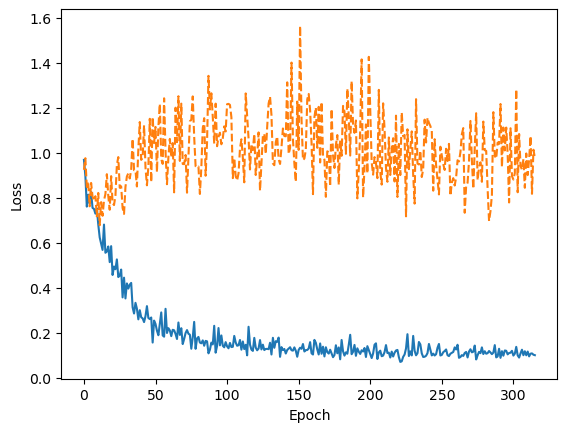

In [59]:
fig, ax = plt.subplots()
loss_avg = np.mean(loss, axis=1)
val_loss_avg = np.mean(val_loss, axis=1)
print(loss_avg.shape)
ax.plot(loss_avg)
ax.plot(val_loss_avg, linestyle="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()
            


In [61]:
model_best = tf.keras.models.load_model("./oxford_segmentation.keras")



1/1 [==============================] - 0s 26ms/step


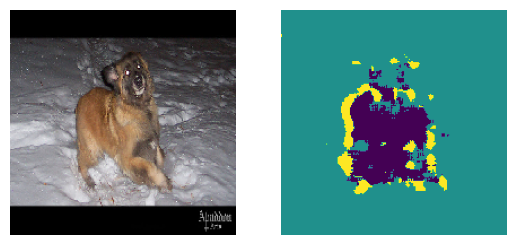

In [69]:
# os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda/"
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
i = 8
fig, (ax1, ax2) = plt.subplots(1, 2)
test_image = val_input_imgs[i]
ax1.axis("off")
ax1.imshow(tf.keras.utils.array_to_img(test_image))

mask = model_best.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    ax2.axis("off")
    ax2.imshow(mask)

display_mask(mask)